# Ginkgo clustering environment

## Setup

In [1]:
%matplotlib inline

import copy
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from tqdm import trange

from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import MlpPolicy as DQNMlpPolicy
from stable_baselines import PPO2, ACER, DQN
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import BaseCallback

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DEnv, GinkgoLikelihoodShuffledEnv, GinkgoEvaluator
from ginkgo_rl import BatchedACERAgent


/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/johannbrehme

In [2]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [3]:
set_output(True)
env = GinkgoLikelihoodEnv(n_max=6, illegal_reward=0., min_reward=None)
state = env.reset()
env.render()

16:33 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
16:33 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
16:33 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 4 leaves
16:33 ginkgo_rl.envs.ginkg INFO    4 particles:
16:33 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  2.7,   1.9,   1.5,   1.4)
16:33 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.5,   0.2,   0.3,   0.3)
16:33 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.4,   0.1,   0.3,   0.3)
16:33 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.4,   0.2,   0.2,   0.3)


In [4]:
for i, (children, p, log_likelihood_split, delta) in enumerate(zip(
    env.jet['tree'], env.jet['content'], env.jet['logLH'], env.jet['deltas']
)):
    if children[0] < 0 and children[1] < 0:
        print(f"{i}: {p}. Leaf.")
    else:
        print(f"{i}: {p}. {i} -> ({children[0]}, {children[1]}) with log p = {log_likelihood_split}, delta = {delta}")

0: [407.92156109 230.94010768 230.94010768 230.94010768]. 0 -> (1, 2) with log p = -14.780177116394043, delta = 6400.0
1: [274.76324501 186.43992502 147.77845311 137.43355321]. Leaf.
2: [133.15831608  44.50018266  83.16165457  93.50655447]. 2 -> (3, 6) with log p = -6.9431562423706055, delta = 91.53475952148438
3: [90.33376393 33.29280968 56.44651762 61.98891463]. 3 -> (4, 5) with log p = -2.891669273376465, delta = 22.9429988861084
4: [41.28462567 16.47870168 24.73867332 28.63578545]. Leaf.
5: [49.0491405  16.81410883 31.7078457  33.35313072]. Leaf.
6: [42.82454883 11.20737187 26.71513488 31.51763751]. Leaf.


In [5]:
# Merge two particles
action = 0, 1

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


16:33 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (0, 1)
16:33 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (0, 1): ti = 0.0, tj = 0.0, t_cut = 16.0, lam = 1.5 -> log likelihood = -11.035697937011719
16:33 ginkgo_rl.envs.ginkg DEBUG   Merging particles 0 and 1. New state has 3 particles.
16:33 ginkgo_rl.envs.ginkg INFO    3 particles:
16:33 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  3.2,   2.0,   1.8,   1.7)
16:33 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.4,   0.1,   0.3,   0.3)
16:33 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.4,   0.2,   0.2,   0.3)


Reward: -11.035697937011719
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 0, 'j': 1}


In [6]:
env.close()

## Env checker

In [7]:
set_output(False)
env = gym.make("GinkgoLikelihoodShuffled-v0")

check_env(env)

for i in range(env.n_max):
    assert i == env.inverse_permutation[env.permutation[i]] == env.permutation[env.inverse_permutation[i]]
    
env.close()

/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:202: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn("Your observation has an unconventional shape (neither an image, nor a 1D vector). "


## Evaluation routine

In [8]:
set_output(False)
evaluator = GinkgoEvaluator()


In [9]:
# True log likelihoods
set_output(False)
evaluator.eval_true("Truth")


In [10]:
# MLE (Trellis)
set_output(False)
evaluator.eval_exact_trellis("ML (Trellis)")


## Random clusterings

In [11]:
set_output(False)
evaluator.eval_random("Random", env_name="GinkgoLikelihood-v0")


/Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


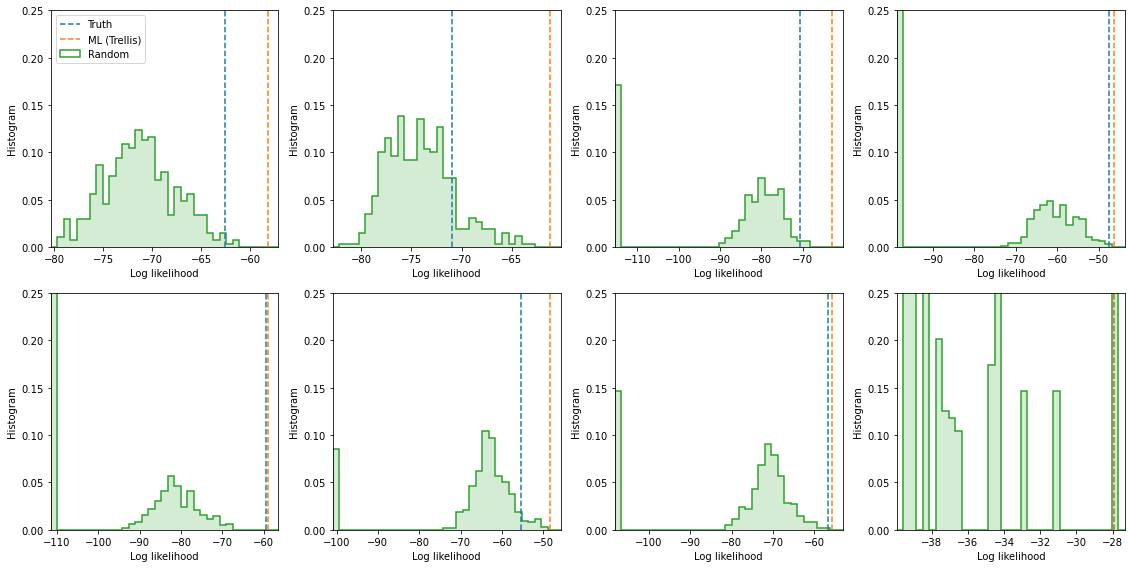

In [12]:
_ = evaluator.plot_log_likelihoods()

## RL preparation

In [13]:
log_dirs = []
models = {}
env_names = {}

def train_baseline(algorithm, algo_class, policy_class, env_name="GinkgoLikelihood1D-v0", n_steps=10000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make(env_name)
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    model = algo_class(policy_class, env, verbose=0)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    env_names[algorithm] = env_name
    env.close()

def train_own(algorithm, algo_class, env_name="GinkgoLikelihood1D-v0", n_steps=10000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make(env_name)
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)
    _ = env.reset()

    model = algo_class(env)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    env_names[algorithm] = env_name
    env.close()


## Training

In [14]:
train_own("acer", BatchedACERAgent)

  0%|          | 23/10000 [00:04<34:34,  4.81it/s]/Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
  7%|▋         | 714/10000 [01:43<22:26,  6.90it/s]


RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, QuantizedCPU, Autograd, Profiler, Tracer, Autocast]

In [ ]:
# train_baseline("ppo", PPO2, MlpPolicy, env_name="GinkgoLikelihood-v0")

In [ ]:
train_baseline("dqn", DQN, DQNMlpPolicy)

## Plot training progress

In [ ]:
results_plotter.plot_results(log_dirs[:], 1e4, results_plotter.X_TIMESTEPS, "Ginkgo")


## Evaluate

In [ ]:
evaluator.eval("ACER", models["acer"], "GinkgoLikelihoodShuffled1D-v0")

In [ ]:
# evaluator.eval("PPO", models["ppo"], "GinkgoLikelihoodShuffled-v0")

In [ ]:
evaluator.eval("DQN", models["dqn"], "GinkgoLikelihoodShuffled1D-v0")

In [ ]:
_ = evaluator.plot_log_likelihoods()